# Skin Cancer Classification using ISIC 2019 Dataset
This notebook explores the ISIC 2019 dataset to classify different types of skin cancer. The workflow includes:
- **Data exploration and preprocessing**
- **Feature extraction using ResNet50**
- **Training multiple ML models**
- **Comparing performance using accuracy & confusion matrix**
- **Implementing a sample prediction system**

## Dataset Overview
The ISIC 2019 dataset contains images of skin lesions categorized into different skin cancer types. We will analyze and classify these images using  machine learning models.
The data contained 25000 images of skin lesions classified with 9 following classes ranging from benign to malignant skin cancer:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.



# 📂 Load and Explore Dataset
We will load:
- **Metadata file**: Contains information about images.
- **Ground truth labels**: Multi-class classification labels.
- **Image files**: Actual skin lesion images.


In [1]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
#import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.utils import resample


Metadata Sample:


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male



Ground Truth Sample:


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


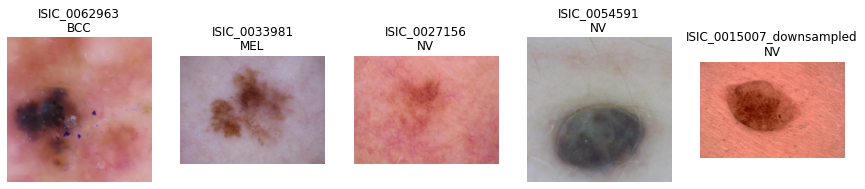

In [2]:
metadata_path = "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv"
groundtruth_path = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
metadata_df = pd.read_csv(metadata_path)
groundtruth_df = pd.read_csv(groundtruth_path)

print("Metadata Sample:")
display(metadata_df.head())

print("\nGround Truth Sample:")
display(groundtruth_df.head())

def display_sample_images(image_list, image_dir, groundtruth_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, img_name + ".jpg")

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_name}.jpg not found!")
            axes[i].set_title("Image Not Found")
            axes[i].axis("off")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error: Failed to load {img_name}.jpg")
            axes[i].set_title("Load Error")
            axes[i].axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        row = groundtruth_df[groundtruth_df['image'] == img_name].iloc[:, 1:]
        cancer_type = row.columns[row.values.argmax()]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{img_name}\n{cancer_type}")

    plt.show()

sample_images = groundtruth_df.sample(5)['image'].values
display_sample_images(sample_images, image_dir, groundtruth_df)


# 📊 Class Distribution
We will visualize the class distribution to understand the imbalance in the dataset.

The graph shows the class distribution of images in the ISIC 2019 dataset, which is used for skin cancer classification. The x-axis represents different types of skin cancer or lesions, while the y-axis shows the number of images corresponding to each category.

Here's a breakdown of the categories and the number of images for each:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.
  
In summary, the dataset is heavily imbalanced, with the "NV" category having significantly more images compared to the other categories. This imbalance might need to be addressed when training machine learning models for skin cancer classification.


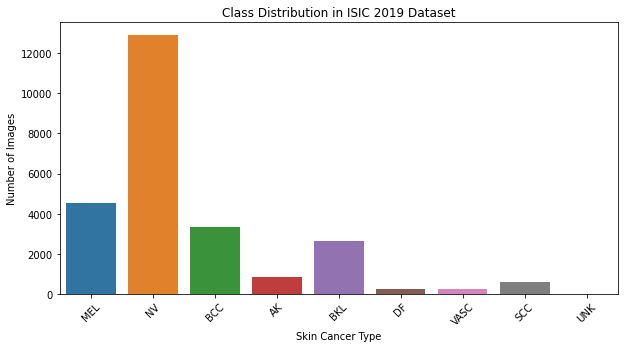

In [3]:
class_counts = groundtruth_df.iloc[:, 1:].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in ISIC 2019 Dataset")
plt.show()


# ⚖️ Handling Class Imbalance in ISIC 2019 Dataset
The dataset is highly **imbalanced**, with some classes containing significantly more images than others. Training a model on an imbalanced dataset can lead to biased predictions.

### 🛠 Methods to Balance Data:
1. **Undersampling**: Reducing the number of samples in the majority class.
2. **Oversampling**: Duplicating samples from minority classes.


Since **undersampling** removes valuable data, we will use **oversampling** by duplicating images from underrepresented classes to match the majority class.


Skipping class 'UNK' because it has no samples.
Balanced Class Distribution:
 MEL     12875.0
NV      12875.0
BCC     12875.0
AK      12875.0
BKL     12875.0
DF      12875.0
VASC    12875.0
SCC     12875.0
UNK         0.0
dtype: float64


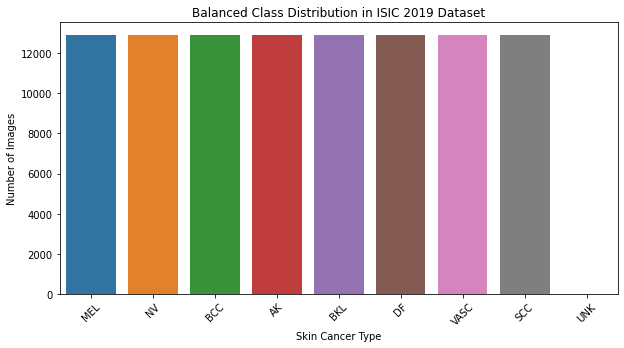

In [4]:
balanced_data = []

max_count = int(groundtruth_df.iloc[:, 1:].sum().max())

for class_name in groundtruth_df.columns[1:]:
    class_subset = groundtruth_df[groundtruth_df[class_name] == 1]

    if len(class_subset) == 0:
        print(f"Skipping class '{class_name}' because it has no samples.")
        continue

    class_upsampled = resample(class_subset, replace=True, n_samples=max_count, random_state=42)

    balanced_data.append(class_upsampled)

balanced_groundtruth_df = pd.concat(balanced_data)

balanced_groundtruth_df = balanced_groundtruth_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_class_counts = balanced_groundtruth_df.iloc[:, 1:].sum()
print("Balanced Class Distribution:\n", balanced_class_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Balanced Class Distribution in ISIC 2019 Dataset")
plt.show()


In [8]:
import os, json
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold

# --------------------------
# Paths
# --------------------------
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
gt_csv    = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"

# --------------------------
# Labels
# --------------------------
df_labels = pd.read_csv(gt_csv)

# All columns except "image" are classes
label_cols = [c for c in df_labels.columns if c.lower() != "image"]
y = df_labels[label_cols].values
y_idx = y.argmax(axis=1)
df_labels["label_idx"] = y_idx

num_classes = len(label_cols)
print("Classes:", label_cols)
print("Total samples:", len(df_labels))

# Save class order for later fusion/inference
with open("image_labels.json", "w") as f:
    json.dump({"label_cols": label_cols}, f, indent=2)

# --------------------------
# Train/Val split
# --------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(df_labels["image"].values, df_labels["label_idx"].values))
train_df = df_labels.iloc[train_idx].reset_index(drop=True)
val_df   = df_labels.iloc[val_idx].reset_index(drop=True)

# Save split indices (optional, for reproducibility)
np.save("train_idx.npy", train_idx)
np.save("val_idx.npy", val_idx)

# --------------------------
# Dataset
# --------------------------
class ISICImageDataset(Dataset):
    def __init__(self, df, image_dir, tfm):
        self.df = df
        self.image_dir = image_dir
        self.tfm = tfm
        self.ids = df["image"].tolist()
        self.labels = df["label_idx"].astype(int).tolist()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        img_id = self.ids[i]
        label  = self.labels[i]
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        if not os.path.isfile(img_path):
            img_path = os.path.join(self.image_dir, f"{img_id}.png")  # fallback
        img = Image.open(img_path).convert("RGB")
        x = self.tfm(img)
        return {"id": img_id, "image": x, "label": label}

# --------------------------
# Transforms
# --------------------------
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# --------------------------
# Dataloaders
# --------------------------
BATCH_SIZE = 32
train_ds = ISICImageDataset(train_df, image_dir, train_tfms)
val_ds   = ISICImageDataset(val_df,   image_dir, val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --------------------------
# ResNet50 Model
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)   # if this errors (no internet), switch to pretrained=False
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# --------------------------
# Training loop
# --------------------------
EPOCHS = 5
for epoch in range(EPOCHS):
    resnet.train()
    total_loss = 0.0
    for batch in train_loader:
        x, yb = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        logits = resnet(x)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss/len(train_loader):.4f}")

# --------------------------
# Save trained model
# --------------------------
torch.save(resnet.state_dict(), "resnet50_image_expert.pt")
print("Saved model: resnet50_image_expert.pt")

# --------------------------
# Collect validation probabilities
# --------------------------
def get_probs(model, loader):
    model.eval()
    all_ids, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["image"].to(device)
            yb = batch["label"].cpu().numpy()
            ids = batch["id"]
            logits = model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            all_ids.extend(ids)
            all_probs.append(probs)
            all_labels.extend(yb)
    return np.array(all_ids, dtype="U64"), np.vstack(all_probs), np.array(all_labels, dtype=np.int64)

val_ids_img, P_val_img, y_val = get_probs(resnet, val_loader)
print("Validation probs shape:", P_val_img.shape)

# --------------------------
# Save FINAL validation artifacts (fixed y_val var name; safe ID dtype)
# --------------------------
np.save("oof_img_probs.npy",  P_val_img)                 # [N_val, num_classes]
np.save("oof_img_labels.npy", y_val)                     # [N_val]
np.save("oof_img_ids.npy",    val_ids_img.astype("U64")) # [N_val], safe string dtype (no pickle)

# Also save the exact class order used
with open("image_artifacts.json", "w") as f:
    json.dump({"label_cols": label_cols}, f, indent=2)

print("Saved: oof_img_probs.npy, oof_img_labels.npy, oof_img_ids.npy, image_artifacts.json")


Classes: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
Total samples: 25331
Epoch 1/5 - Train Loss: 0.8690
Epoch 2/5 - Train Loss: 0.6654
Epoch 3/5 - Train Loss: 0.5662
Epoch 4/5 - Train Loss: 0.4894
Epoch 5/5 - Train Loss: 0.4191
Saved model: resnet50_image_expert.pt
Validation probs shape: (5067, 9)
Saved: oof_img_probs.npy, oof_img_labels.npy, oof_img_ids.npy, image_artifacts.json


In [9]:
# ============================================================
# 2) METADATA BRANCH — CatBoost (fallback to XGB/LR) + val probs
# ============================================================
import os, json, numpy as np, pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Optional libs
USE_CAT = True
try:
    from catboost import CatBoostClassifier, Pool
except Exception:
    USE_CAT = False

USE_XGB = False
if not USE_CAT:
    try:
        from xgboost import XGBClassifier
        USE_XGB = True
    except Exception:
        pass

# --------------------------
# Paths
# --------------------------
gt_csv  = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
meta_csv_candidates = [
    "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv",
    "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata/ISIC_2019_Training_Metadata.csv",
]
assert os.path.exists(gt_csv)
meta_csv = next((p for p in meta_csv_candidates if os.path.exists(p)), None)
assert meta_csv is not None, "Metadata CSV not found."

# Load class order from image step
with open("labels.json") as f:
    label_cols = json.load(f)["label_cols"]
num_classes = len(label_cols)

val_ids = np.load("val_ids.npy").astype("U64")

# --------------------------
# Load GT/metadata + engineer features
# --------------------------
df_labels = pd.read_csv(gt_csv)[["image"] + label_cols]
y_oh = df_labels[label_cols].values
assert (y_oh.sum(axis=1) == 1).all()
df_labels["label_idx"] = y_oh.argmax(axis=1)

df_meta = pd.read_csv(meta_csv)

# unify site
site_cols = [c for c in ["anatom_site_general","anatom_site_general_challenge"] if c in df_meta.columns]
def unify_site(row):
    for c in site_cols:
        if c in row and pd.notna(row[c]) and str(row[c]).strip() != "":
            return str(row[c]).strip()
    return "unknown"
df_meta["anatom_site_unified"] = df_meta.apply(unify_site, axis=1)

# clean sex
if "sex" in df_meta.columns:
    df_meta["sex"] = df_meta["sex"].astype(str).str.lower().fillna("unknown")
    df_meta.loc[~df_meta["sex"].isin(["male","female","unknown"]), "sex"] = "unknown"
else:
    df_meta["sex"] = "unknown"

# age + age^2
if "age_approx" in df_meta.columns:
    df_meta["age_approx"] = pd.to_numeric(df_meta["age_approx"], errors="coerce")
else:
    df_meta["age_approx"] = np.nan
df_meta["age_sq"] = df_meta["age_approx"] ** 2

# interaction
df_meta["sex_x_site"] = df_meta["sex"].astype(str) + "|" + df_meta["anatom_site_unified"].astype(str)

# merge
df_all = df_labels.merge(df_meta, on="image", how="left")

# feature lists
num_feats = [c for c in ["age_approx","age_sq"] if c in df_all.columns]
cat_feats = [c for c in ["sex","anatom_site_unified","sex_x_site"] if c in df_all.columns]

# rare category collapse
def collapse_rare(frame, cols, min_count=10, other="other"):
    frame = frame.copy()
    for col in cols:
        if col in frame.columns:
            vc = frame[col].value_counts(dropna=False)
            rare = vc[vc < min_count].index
            frame[col] = frame[col].where(~frame[col].isin(rare), other)
    return frame

df_all = collapse_rare(df_all, cat_feats, min_count=10, other="other")

# Split using same val_ids from image step
is_val = df_all["image"].isin(set(val_ids))
tr_df = df_all.loc[~is_val].reset_index(drop=True)
va_df = df_all.loc[ is_val].reset_index(drop=True)

X_tr = tr_df[num_feats + cat_feats].copy()
y_tr = tr_df["label_idx"].values
X_va = va_df[num_feats + cat_feats].copy()
y_va = va_df["label_idx"].values
val_ids_meta = va_df["image"].to_numpy(dtype="U64")

print("Train size:", len(X_tr), "| Val size:", len(X_va))

# --------------------------
# Train model (CatBoost → XGB → LR)
# --------------------------
if USE_CAT:
    print("Model: CatBoostClassifier")
    feature_cols = list(X_tr.columns)
    cat_idx = [feature_cols.index(c) for c in cat_feats if c in feature_cols]
    train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
    valid_pool = Pool(X_va, y_va, cat_features=cat_idx)

    clf = CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="TotalF1",
        learning_rate=0.05,
        depth=6, l2_leaf_reg=5.0,
        iterations=1200, random_seed=42,
        od_type="Iter", od_wait=60, verbose=False
    )
    # inverse-frequency class weights
    classes, counts = np.unique(y_tr, return_counts=True)
    weights = {int(c): float(counts.max()/cnt) for c, cnt in zip(classes, counts)}
    clf.set_params(class_weights=weights)

    clf.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    P_va = clf.predict_proba(valid_pool)

    # save model
    import joblib
    joblib.dump({"clf": clf, "cat_idx": cat_idx, "num_feats": num_feats, "cat_feats": cat_feats},
                "meta_only_catboost.pkl")

elif USE_XGB:
    print("Model: XGBoost")
    from xgboost import XGBClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler

    numeric_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                           ("sc",  StandardScaler())])
    categorical_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                               ("oh",  OneHotEncoder(handle_unknown="ignore", sparse=True))])
    preproc = ColumnTransformer([("num", numeric_tf, num_feats), ("cat", categorical_tf, cat_feats)])
    xgb = XGBClassifier(
        n_estimators=1200, learning_rate=0.03, max_depth=5,
        subsample=0.9, colsample_bytree=0.8,
        reg_lambda=2.0, objective="multi:softprob", num_class=num_classes,
        tree_method="hist", eval_metric="mlogloss", random_state=42, n_jobs=-1
    )
    pipe = Pipeline([("pre", preproc), ("clf", xgb)])
    pipe.fit(X_tr, y_tr)
    P_va = pipe.predict_proba(X_va)
    import joblib
    joblib.dump(pipe, "meta_only_xgb.pkl")

else:
    print("Model: LogisticRegression")
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler

    numeric_tf = Pipeline([("imp", SimpleImputer(strategy="median")),
                           ("sc",  StandardScaler())])
    categorical_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                               ("oh",  OneHotEncoder(handle_unknown="ignore", sparse=True))])
    preproc = ColumnTransformer([("num", numeric_tf, num_feats), ("cat", categorical_tf, cat_feats)])
    lr = LogisticRegression(max_iter=4000, multi_class="multinomial",
                            class_weight="balanced", solver="lbfgs", random_state=42)
    pipe = Pipeline([("pre", preproc), ("clf", lr)])
    pipe.fit(X_tr, y_tr)
    P_va = pipe.predict_proba(X_va)
    import joblib
    joblib.dump(pipe, "meta_only_logreg.pkl")

print("Val probs (meta) shape:", P_va.shape)

# --------------------------
# Save validation OOF for fusion
# --------------------------
np.save("oof_meta_probs.npy", P_va)
np.save("oof_meta_labels.npy", y_va)
np.save("oof_meta_ids.npy", val_ids_meta)
print("Saved: oof_meta_probs.npy, oof_meta_labels.npy, oof_meta_ids.npy")


Train size: 20264 | Val size: 5067
Model: CatBoostClassifier
Val probs (meta) shape: (5067, 8)
Saved: oof_meta_probs.npy, oof_meta_labels.npy, oof_meta_ids.npy


In [13]:
# ============================================
# FUSE IMAGE + METADATA with CLASS NAME ALIGNMENT
# ============================================
import os, json, numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ---------- Helpers ----------
def load_ids(path):
    arr = np.load(path, allow_pickle=True)
    return arr.astype("U64")

def try_load_labels(paths):
    for p in paths:
        if os.path.exists(p):
            try:
                with open(p) as f:
                    d = json.load(f)
                if "label_cols" in d:
                    return d["label_cols"]
            except Exception:
                pass
    return None

def fuse(Pa, Pb, alpha):
    return alpha * Pa + (1.0 - alpha) * Pb

def alpha_sweep(Pa, Pb, y, alphas=np.linspace(0,1,21)):
    best = {"alpha": None, "acc": -1.0, "macro_f1": -1.0}
    for a in alphas:
        Pf = fuse(Pa, Pb, a)
        yhat = Pf.argmax(axis=1)
        acc  = accuracy_score(y, yhat)
        mf1  = f1_score(y, yhat, average="macro")
        if mf1 > best["macro_f1"]:
            best.update({"alpha": float(a), "acc": float(acc), "macro_f1": float(mf1)})
    return best

def tune_thresholds(P, y, grid=np.linspace(0.2,0.85,34), passes=2):
    K = P.shape[1]
    t = np.ones(K, dtype=np.float32)
    for _ in range(passes):
        for k in range(K):
            best_tk, best_f1 = t[k], -1.0
            for tk in grid:
                tt = t.copy(); tt[k] = tk
                pred = (P / tt).argmax(axis=1)
                mf1  = f1_score(y, pred, average="macro")
                if mf1 > best_f1:
                    best_f1, best_tk = mf1, tk
            t[k] = best_tk
    pred = (P / t).argmax(axis=1)
    return t, pred, f1_score(y, pred, average="macro"), accuracy_score(y, pred)

# ---------- Load OOF artifacts ----------
# Image
P_img   = np.load("oof_img_probs.npy")           # [N_img, K_img]
y_img   = np.load("oof_img_labels.npy")
ids_img = load_ids("oof_img_ids.npy")

# Metadata
P_meta   = np.load("oof_meta_probs.npy")         # [N_meta, K_meta]
y_meta   = np.load("oof_meta_labels.npy")
ids_meta = load_ids("oof_meta_ids.npy")

# ---------- Align by IDs ----------
id2row_meta = {iid: r for r, iid in enumerate(ids_meta)}
keep_img, keep_meta = [], []
for r_img, iid in enumerate(ids_img):
    if iid in id2row_meta:
        keep_img.append(r_img)
        keep_meta.append(id2row_meta[iid])

keep_img  = np.asarray(keep_img, dtype=int)
keep_meta = np.asarray(keep_meta, dtype=int)
assert keep_img.size > 0, "No overlapping IDs."

P_img_aln  = P_img[keep_img]
P_meta_aln = P_meta[keep_meta]
y_true     = y_meta[keep_meta]

# ---------- Load class name lists (for alignment) ----------
img_labels  = try_load_labels(["image_artifacts.json", "image_labels.json"])
meta_labels = try_load_labels(["labels.json", "meta_only_thresholds.json", "image_artifacts.json"])

# ---------- Reconcile class mismatch by NAME ----------
if P_img_aln.shape[1] != P_meta_aln.shape[1]:
    assert img_labels is not None and meta_labels is not None, \
        "Class count mismatch and label names not found. Save label_cols JSON from both branches."

    # Build mapping from META order -> indices in IMAGE labels
    miss = [c for c in meta_labels if c not in (img_labels or [])]
    assert len(miss) == 0, f"Meta class not found in image labels: {miss}"

    idx_in_img = [img_labels.index(c) for c in meta_labels]  # drop/reorder image probs to meta order
    P_img_aln = P_img_aln[:, idx_in_img]

    # Renormalize after dropping a column
    s = P_img_aln.sum(axis=1, keepdims=True)
    P_img_aln = np.divide(P_img_aln, np.maximum(s, 1e-12), where=(s>0))

    print(f"Aligned by class names. Image K={len(img_labels)} → Meta K={len(meta_labels)}")
    # From here on, we use meta_labels as the canonical class order
    label_cols = meta_labels
else:
    label_cols = meta_labels or img_labels

# Final sanity
assert P_img_aln.shape[1] == P_meta_aln.shape[1], "Failed to align class dimensions."
K = P_img_aln.shape[1]

# ---------- Alpha sweep ----------
best = alpha_sweep(P_img_aln, P_meta_aln, y_true)
print(f"[Argmax] Best α={best['alpha']:.2f} | Acc={best['acc']:.4f} | Macro-F1={best['macro_f1']:.4f}")

# ---------- Threshold tuning ----------
P_fused = fuse(P_img_aln, P_meta_aln, best["alpha"])
tuned_t, tuned_pred, tuned_macro, tuned_acc = tune_thresholds(P_fused, y_true)
print(f"[Fused+Tuned] Macro-F1={tuned_macro:.4f} | Acc={tuned_acc:.4f}")

print("\nClassification report (fused + tuned):")
print(classification_report(y_true, tuned_pred, target_names=label_cols if label_cols and len(label_cols)==K else None,
                            digits=4, zero_division=0))

# ---------- Save fusion artifacts ----------
np.save("oof_fused_probs.npy",  P_fused)
np.save("oof_fused_pred.npy",   tuned_pred)
np.save("oof_fused_ids.npy",    ids_img[keep_img])
np.save("oof_fused_labels.npy", y_true)

with open("fusion_artifacts.json", "w") as f:
    json.dump({
        "alpha": float(best["alpha"]),
        "thresholds": [float(x) for x in tuned_t],
        "label_cols": label_cols
    }, f, indent=2)

print("Saved: oof_fused_probs.npy, oof_fused_pred.npy, oof_fused_ids.npy, oof_fused_labels.npy, fusion_artifacts.json")


Aligned by class names. Image K=9 → Meta K=8
[Argmax] Best α=0.50 | Acc=0.7896 | Macro-F1=0.6869
[Fused+Tuned] Macro-F1=0.6947 | Acc=0.7894

Classification report (fused + tuned):
              precision    recall  f1-score   support

         MEL     0.6725    0.6851    0.6787       905
          NV     0.8801    0.8812    0.8807      2575
         BCC     0.7761    0.8496    0.8112       665
          AK     0.4721    0.6322    0.5405       174
         BKL     0.7674    0.5657    0.6513       525
          DF     0.8438    0.5745    0.6835        47
        VASC     0.6949    0.8200    0.7523        50
         SCC     0.5547    0.5635    0.5591       126

    accuracy                         0.7894      5067
   macro avg     0.7077    0.6965    0.6947      5067
weighted avg     0.7934    0.7894    0.7889      5067

Saved: oof_fused_probs.npy, oof_fused_pred.npy, oof_fused_ids.npy, oof_fused_labels.npy, fusion_artifacts.json
